<a href="https://colab.research.google.com/github/jecampagne/ML-toys/blob/main/CNN_MNIST_alternative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import sys,os
from importlib import reload


In [5]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'mnist',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

num_classes = metadata.features['label'].num_classes
print(num_classes)


rescale = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomRotation(factor=(-0.07,0.07)), # fraction of +/- 2pi
  tf.keras.layers.RandomTranslation(height_factor=(-0.05,0.05),width_factor=(-0.05,0.05),
                                    fill_mode='constant',fill_value=0.0) # fraction on height/width
])

batch_size = 256
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: tf.cond(tf.random.uniform([], 0, 1) > 0.50, 
                                    lambda: (data_augmentation(x, training=True), y), 
                                    lambda: (x,y)), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)



train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)


Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
10


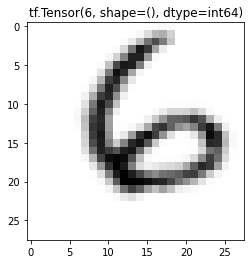

In [7]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image[2][:,:,0], cmap='gray_r')
_ = plt.title(get_label_name(label[2]))


In [8]:
model = keras.models.Sequential()

model.add( keras.layers.Input((28,28,1)) )

model.add( keras.layers.Conv2D(512, (5,5),  activation='relu') )
model.add(keras.layers.BatchNormalization())
model.add( keras.layers.AveragePooling2D((2,2)))
model.add( keras.layers.Conv2D(64, (1,1), activation='relu') )


model.add( keras.layers.Conv2D(512, (3,3), activation='relu') )
model.add(keras.layers.BatchNormalization())
model.add( keras.layers.AveragePooling2D((2,2)))
model.add( keras.layers.Conv2D(64, (1,1), activation='relu') )




model.add( keras.layers.Flatten()) 
model.add( keras.layers.Dense(num_classes, activation='softmax'))

In [9]:
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 512)       13312     
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 512)      2048      
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 12, 12, 512)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 512)       295424    
                                                                 
 batch_normalization_1 (Batc  (None, 10, 10, 512)     

In [11]:
epochs      = 50

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    min_lr=1e-5,
    verbose=1)


history = model.fit(  train_ds,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = 1,
                      validation_data = val_ds,
                    callbacks=[reduce_lr])

Epoch 1/50
188/188 [==============================] - 30s 116ms/step - loss: 0.1885 - accuracy: 0.9408 - val_loss: 4.2710 - val_accuracy: 0.0987 - lr: 0.0010
Epoch 2/50
188/188 [==============================] - 20s 105ms/step - loss: 0.0724 - accuracy: 0.9780 - val_loss: 3.4192 - val_accuracy: 0.1608 - lr: 0.0010
Epoch 3/50
188/188 [==============================] - 21s 110ms/step - loss: 0.0543 - accuracy: 0.9837 - val_loss: 0.4331 - val_accuracy: 0.8452 - lr: 0.0010
Epoch 4/50
188/188 [==============================] - 22s 116ms/step - loss: 0.0513 - accuracy: 0.9842 - val_loss: 0.0533 - val_accuracy: 0.9838 - lr: 0.0010
Epoch 5/50
188/188 [==============================] - 22s 114ms/step - loss: 0.0410 - accuracy: 0.9870 - val_loss: 0.0455 - val_accuracy: 0.9858 - lr: 0.0010
Epoch 6/50
188/188 [==============================] - 21s 112ms/step - loss: 0.0381 - accuracy: 0.9883 - val_loss: 0.0462 - val_accuracy: 0.9863 - lr: 0.0010
Epoch 7/50
188/188 [==============================] 

In [12]:
history

In [16]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

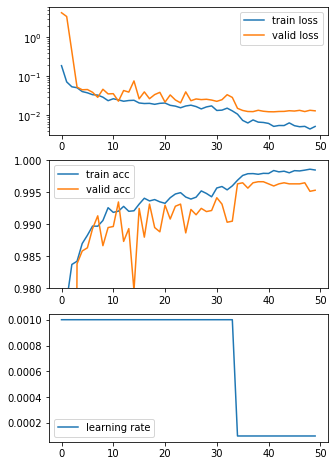

In [27]:
fig,ax=plt.subplots(3,1,figsize=(5,8))
ax[0].plot(history.history['loss'], label='train loss')
ax[0].plot(history.history['val_loss'], label='valid loss')
ax[0].set_yscale('log')
ax[0].legend()
ax[1].plot(history.history['accuracy'], label='train acc')
ax[1].plot(history.history['val_accuracy'], label='valid acc')
ax[1].set_ylim([0.98,1.0])
ax[1].legend()

ax[2].plot(history.history['lr'], label='learning rate')
ax[2].legend();
